Hyperparameters DONE:

    1. 11.directional change threshold (d)
    2. TMV
    3. asset
  
Hyperparameters TO DO: 

    1. invert the regimes (trend following with normal instead of abnormal)
    2. regime dependent TMV 
    3. trend dependent TMV
    4. regime and trend dependent TMV
    5. percentile TMV (empirical or parametric distirbution fitted to the historical TMV)
    6. regime dependent direction change threshold (d depdendent on the regime)
    7. no regimes   
    9.frequency (1h, ...)
        
    

# IMPORT AND CONFIGURATION

In [1]:
from datetime import datetime
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
import yfinance as yf
from tqdm import tqdm
import os
import warnings
from os import listdir
from os.path import isfile, join
import pickle

idx = pd.IndexSlice

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 60%; }
</style>
"""))

In [2]:
cwd=os.getcwd()

# FUNCTIONS

In [3]:
def generate(data, d=0.1):
    #Generates directional change events from time series.
    #Based on:
    #    M. Aloud, E. Tsang, R. B. Olsen, and A. Dupuis, "A Directional-Change Events Approach for Studying Financial Time Series," 2012.
    #Args:
    #    data: pandas.Series or array of floats
    #    d: Directional Change threshold
    #Returns:
    #    A pandas series of Directional Change Events.
    
    p = pd.DataFrame({
    "Price": data.values
    })
    p["Event"] = ''
    event = 'DC+' #default
    #DC+, DC-, OS+, OS-
    p["DC_price"]=''
    p["ret"]=''
    p["PL/PH"]=''
    p["turning_point"]=''
    p["time"]=''
    p["PH"]=p['Price'][0]
    p["PL"]=p['Price'][0]
    ph = p['Price'][0] # highest price
    pl = p['Price'][0] # lowest price
    last_os_index=0
    

    for i in range(0, len(p)):
        
        p.loc[i, 'time']=data.index[i]
        
        if i==0:
            max_p=p['Price'][i]
            min_p=p['Price'][i]
        
        if i!=0:
            p.loc[i, 'ret'] = (p['Price'][i] - p['Price'][i -1])/p['Price'][i -1]

        #uptrend
        if event in ['DC+','OS+']: 
            if p['Price'][i] <= (ph * (1 - d)):
                event = 'DC-'
                max_p=p['Price'][i]
                p.loc[last_os_index,"turning_point"] = p.loc[last_os_index, "Price"]               
                p.loc[i,"turning_point"]=max_p
                pl = p['Price'][i]
                p.loc[i,"PL"]=pl
                p.loc[i, 'DC_price'] = pl
                p.loc[i, 'PL/PH'] = "pl"
                p.loc[i, 'Event'] = 'DC-'
                p.loc[i + 1, 'Event'] = 'OS-' #temporarily
                
                
            
            else:
                if p['Price'][i] > ph:
                    ph = p['Price'][i]
                    p.loc[i,"PH"]=ph
                    p.loc[i, 'DC_price'] = ph
                    p.loc[i, 'PL/PH'] = "ph"
                    if p['Price'][i] > (min_p * (1 + d)):
                        p.loc[i, 'Event'] = 'OS+' 
                        last_os_index = i
#                         p.loc[i,"turning_point"] = max_p
#                     p.loc[i - 1, 'Event'] = 'end upward os'
                    
        
        #downtrend
        else:
            if p['Price'][i] >= (pl * (1 + d)):
                event = 'DC+'
                min_p=p['Price'][i]
                p.loc[last_os_index,"turning_point"] = p.loc[last_os_index, "Price"]  
                p.loc[i,"turning_point"]=min_p
                ph = p['Price'][i]
                p.loc[i,"PH"]=ph
                p.loc[i, 'DC_price'] = ph
                p.loc[i, 'PL/PH'] = "ph"
                p.loc[i, 'Event'] = 'DC+'
                p.loc[i + 1, 'Event'] = 'OS+' #temporarily                           
            else:
                if p['Price'][i] < pl:
                    pl = p['Price'][i]
                    p.loc[i,"PL"]=pl
                    p.loc[i, 'DC_price'] = pl
                    p.loc[i, 'PL/PH'] = "pl"
                    if p['Price'][i] < (max_p * (1 - d)):
                        p.loc[i, 'Event'] = 'OS-'
                        last_os_index = i
#                         p.loc[i,"turning_point"] = min_p
#                     p.loc[i - 1, 'Event'] = 'end downward os'
    
    
    p["time"]=pd.to_datetime(p["time"])
    return p

In [4]:
def TMV_R(dataset, theta):
    """
    dataset: is a pandas.dataframe that contains the prices (col1) and events (col2)
    """
    dataset_original=dataset.copy()
    dataset=dataset.reset_index()
    TMV=dataset[dataset.loc[:,"Event"].str.startswith("DC")]["Price"].pct_change(1).abs().dropna()/theta
    T=dataset[dataset.loc[:,"Event"].str.startswith("DC")].index.to_series().diff().dropna()

    dataset=pd.merge(dataset,
             T.to_frame(),
             how="left", right_index=True, left_index=True).rename(columns={0:"T"})
    dataset=pd.merge(dataset,
             TMV,
             how="left", right_index=True, left_index=True).rename(columns={"Price_y":"TMV", "Price_x":"Price"})
    dataset.loc[:,"R"]=dataset["TMV"]*theta/dataset["T"]
    dataset.set_index('time', inplace=True) 
    
    dataset["DC_price"]=pd.to_numeric(dataset["DC_price"])
    dataset["turning_point"]=pd.to_numeric(dataset["turning_point"])
    dataset["ret"]=pd.to_numeric(dataset["ret"])
    dataset["Price"]=pd.to_numeric(dataset["Price"])
    
    return dataset

In [5]:
def data_loading(symbol, folder):
    # Download and Prepare the data
    path = os.path.join(cwd, "data", "{}.csv".format(symbol))
#     r"C:/Andrea/Tutoring/Tutoring Coding/Jean-Baptiste/Project/dc_strategy/data/{symbol}.csv"
    df = pd.read_csv(path.format(symbol=symbol.replace("/", "")), header=[0], parse_dates=['Timestamp'])
    return df

def data_cleaning(df, Time):
    df = df.set_index('Timestamp')
    df = df.resample(Time).mean()
    df = df.dropna()
    return df

In [6]:
def best_hp_for_one_metric(back_testing_results, metric="total_trade_returns"):
    back_testing_results_bkp=back_testing_results.copy()
    back_testing_results_bkp.reset_index(inplace=True)
    back_testing_results_bkp.set_index(["asset","dc_threshold", "TMV_threshold"], inplace=True)
    
    best_hp=pd.DataFrame()
    for m in ["total_trade_returns"]+back_testing_results_bkp.columns[-6:].to_list():
        best_hp_tmp=back_testing_results_bkp.groupby("asset")[m].idxmax()
        best_hp=pd.concat([best_hp, best_hp_tmp], axis=1)
    
    res=pd.DataFrame()
    for a in best_hp.index.get_level_values(0):
        hp=best_hp.loc[a,metric]
        res_tmp=back_testing_results_bkp.loc[hp].to_frame().dropna().T
        res=pd.concat([res, res_tmp], axis=0)
    return res

In [7]:
def best_hp_for_one_metric_and_constrain(back_testing_results, metric="total_trade_returns", constrain_metric="VaR_hist", constrain_value=-0.005):
    back_testing_results_bkp=back_testing_results.copy()
    back_testing_results_bkp.reset_index(inplace=True)
    back_testing_results_bkp.set_index(["asset","dc_threshold", "TMV_threshold"], inplace=True)
    back_testing_results_bkp=back_testing_results_bkp[back_testing_results_bkp[constrain_metric]>constrain_value]
    
    best_hp=pd.DataFrame()
    for m in ["total_trade_returns"]+back_testing_results_bkp.columns[-6:].to_list():
        best_hp_tmp=back_testing_results_bkp.groupby("asset")[m].idxmax()
        best_hp=pd.concat([best_hp, best_hp_tmp], axis=1)
    
    res=pd.DataFrame()
    for a in best_hp.index.get_level_values(0):
        hp=best_hp.loc[a,metric]
        res_tmp=back_testing_results_bkp.loc[hp].to_frame().dropna().T
        res=pd.concat([res, res_tmp], axis=0)
    return res

In [142]:
def TMV_trailing(dataset,theta=0.001):
    dataset.reset_index(inplace=True)
    dataset.set_index("index",inplace=True)
    dataset.loc[:,"TMV_trailing"]=np.nan
    # intrend=False
    # for i in range(0, len(dataset)):
    #     if intrend==False: #not in a trend
    #         if dataset.loc[i,"Event"] in ["DC+", "DC-"]: #not in a trend and now I found beginning of a new trend
    # #             print("beginning of a trend", i)
    #             trend_beginning_p=dataset.loc[i,"Price"] #save the price at the beginning of a new trend
    # #             print(trend_beginning_p)
    #             intrend=True
    #             continue
    #     elif intrend==True: #in a trend
    #         TMV_trailing=abs((dataset.loc[i,"Price"]-trend_beginning_p)/trend_beginning_p/theta)
    #         dataset.loc[i,"TMV_trailing"]=TMV_trailing
    # #         print(TMV_trailing, i)  
    #         if dataset.loc[i,"Event"] in ["DC+", "DC-"]: #i a trend and I found the end of the trend
    #             intrend=False
    #             TMV_trailing=np.nan
    TMV_trailing=np.nan
    trend_beginning_p=np.nan
    for i in range(0, len(dataset)):
        if not(np.isnan(TMV_trailing)):
            TMV_trailing=abs((dataset.loc[i,"Price"]-trend_beginning_p)/trend_beginning_p/theta)
            dataset.loc[i,"TMV_trailing"]=TMV_trailing

        if dataset.loc[i,"Event"] in ["DC+", "DC-"]: 
            TMV_trailing=abs((dataset.loc[i,"Price"]-trend_beginning_p)/trend_beginning_p/theta)
            trend_beginning_p=dataset.loc[i,"Price"]

    dataset.set_index("time",inplace=True)
    return dataset

# STRATEGY RUN EXAMPLE

## DATA DOWNLOAD/LOAD

In [8]:
asset = data_loading('EURUSD', cwd)
asset = data_cleaning(asset, '1H')
asset['midPrice'] = (asset['bidPrice']+asset['offerPrice'])/2
asset

,bidPrice,offerPrice,midPrice
Timestamp,,,
2020-12-30 11:00:00,1.227206,1.227234,1.227220
2020-12-30 12:00:00,1.227962,1.227990,1.227976
2020-12-30 13:00:00,1.228425,1.228451,1.228438
2020-12-30 14:00:00,1.228900,1.228930,1.228915
2020-12-30 15:00:00,1.229135,1.229162,1.229148
...,...,...,...
2021-11-29 19:00:00,1.126997,1.127043,1.127020
2021-11-29 20:00:00,1.127902,1.127948,1.127925
2021-11-29 21:00:00,1.128573,1.128631,1.128602


In [9]:
asset["ret"]=asset["midPrice"].pct_change(1)
asset.dropna(inplace=True)
asset_r=asset.loc[:,"ret"]
asset_r

Timestamp
2020-12-30 12:00:00    0.000616
2020-12-30 13:00:00    0.000376
2020-12-30 14:00:00    0.000389
2020-12-30 15:00:00    0.000190
2020-12-30 16:00:00   -0.000161
                         ...   
2021-11-29 19:00:00   -0.000063
2021-11-29 20:00:00    0.000803
2021-11-29 21:00:00    0.000600
2021-11-29 22:00:00    0.000240
2021-11-29 23:00:00    0.000548
Name: ret, Length: 5157, dtype: float64

In [10]:
asset_p=asset["midPrice"]
asset_p=asset_p.dropna()
asset_p

Timestamp
2020-12-30 12:00:00    1.227976
2020-12-30 13:00:00    1.228438
2020-12-30 14:00:00    1.228915
2020-12-30 15:00:00    1.229148
2020-12-30 16:00:00    1.228951
                         ...   
2021-11-29 19:00:00    1.127020
2021-11-29 20:00:00    1.127925
2021-11-29 21:00:00    1.128602
2021-11-29 22:00:00    1.128873
2021-11-29 23:00:00    1.129492
Name: midPrice, Length: 5157, dtype: float64

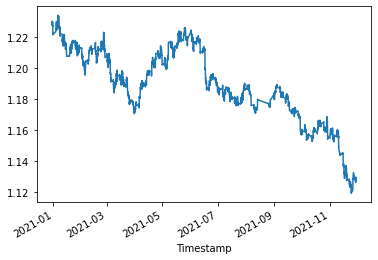

In [11]:
asset_p.plot()
plt.show()

check whether there are some missing minute observations

<AxesSubplot:xlabel='Timestamp'>

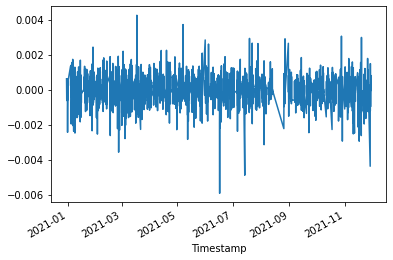

In [12]:
asset_r.plot()

## MODEL ESTIMATION

Best MS model search

In [338]:
k_regimes=[2]
order=[1,2,3]
switching_ar=[True, False]
switching_variance=[True, False]

In [ ]:
BIC=[]
for k in k_regimes:
    for o in order:           
        for s_ar in switching_ar:
            for s_variance in switching_variance:
                if o==0 & s_ar==True:
                    continue
                BIC_tmp=pd.DataFrame()
                mod_hamilton = sm.tsa.MarkovAutoregression(eurusd, k_regimes=k, order=o, switching_ar=s_ar, switching_variance=s_variance, trend='c')
                res_hamilton = mod_hamilton.fit()
                BIC_tmp.loc[0,"k"]=k
                BIC_tmp.loc[0,"ar_order"]=o
                BIC_tmp.loc[0,"s_ar"]=s_ar
                BIC_tmp.loc[0,"s_var"]=s_variance
                BIC_tmp.loc[0,"BIC"]=res_hamilton.bic
                BIC.append(BIC_tmp)

In [ ]:
BIC=pd.concat(BIC, axis=0).set_index(["k","ar_order","s_ar","s_var"])
BIC

In [ ]:
pd.concat(BIC, axis=0)["BIC"].idxmin()


SIngle MS model estimation

In [13]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(
    asset_r, k_regimes=2, order=2, switching_ar=True, switching_variance=True, trend='c'
)
res_hamilton = mod_hamilton.fit()

In [14]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      ret   No. Observations:                 5155
Model:             MarkovAutoregression   Log Likelihood               31764.632
Date:                  Sat, 19 Feb 2022   AIC                         -63509.264
Time:                          18:14:08   BIC                         -63443.786
Sample:                               0   HQIC                        -63486.350
                                 - 5155                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.734e-06   8.12e-06      0.583      0.560   -1.12e-05    2.07e-05
sigma2      8.598e-08        nan        nan        nan         nan         nan
ar.L1          0.2158      0.022      9.723      0.000       0.172       0.259
ar.L2         -0.0533      0.019     -2.820      0.005      -0.090      -0.016
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.97e-05   2.17e-05     -2.288      0.022   -9.23e-05   -7.13e-06
sigma2      7.416e-07        nan        nan        nan         nan         nan
ar.L1          0.2195      0.031      7.080      0.000       0.159       0.280
ar.L2         -0.0781      0.033     -2.349      0.019      -0.143      -0.013
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8676      0.008    112.493      0.000       0.852       0.883
p[1->0]        0.2191      0.002    112.892      0.000       0.215       0.223
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

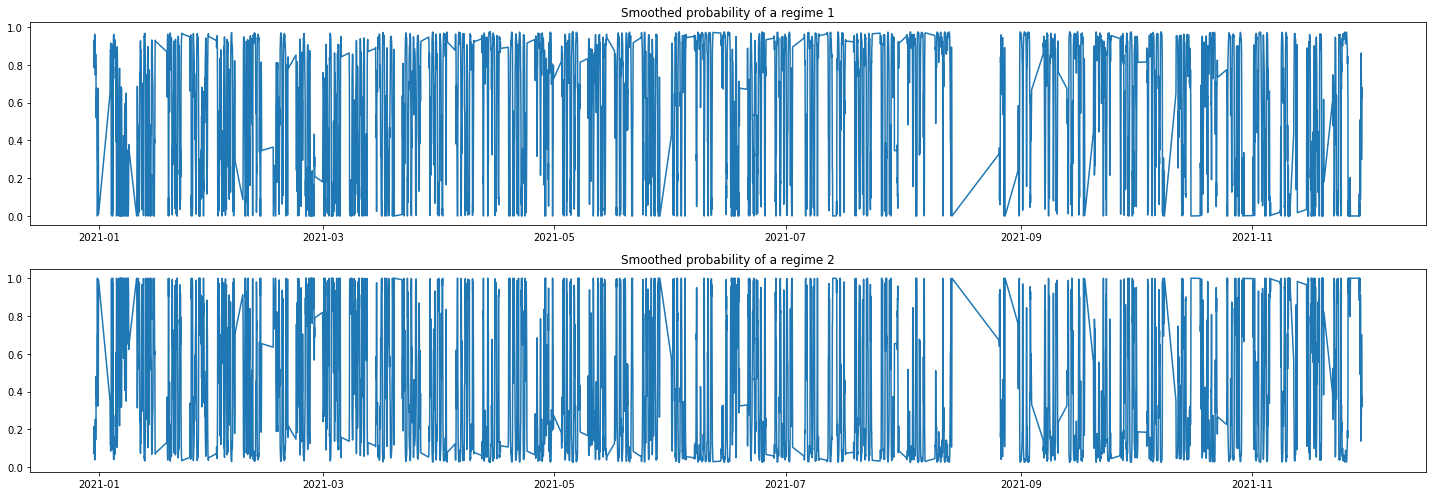

In [15]:
fig, axes = plt.subplots(2, figsize=(20, 7))

ax = axes[0]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a regime 1")

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a regime 2")

fig.tight_layout()

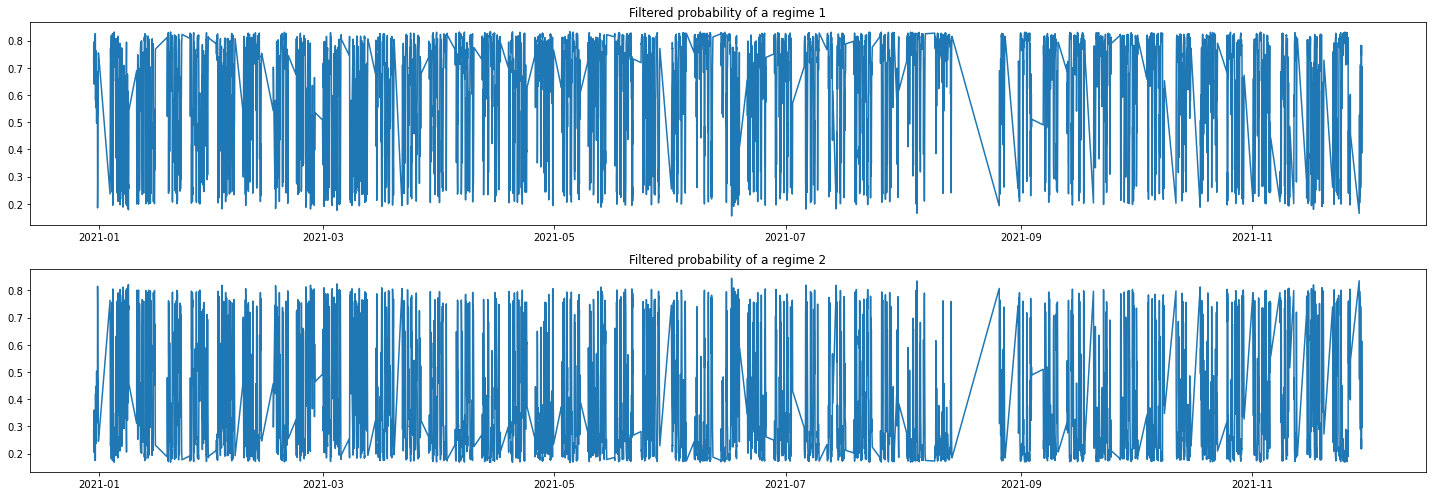

In [16]:
fig, axes = plt.subplots(2, figsize=(20, 7))

ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.set(title="Filtered probability of a regime 1")

ax = axes[1]
ax.plot(res_hamilton.filtered_marginal_probabilities[1])
ax.set(title="Filtered probability of a regime 2")

fig.tight_layout()

**Regime classification**

In [17]:
print(res_hamilton.expected_durations)

[7.55260861 4.56398246]


In [18]:
normal_regime=pd.Series(res_hamilton.expected_durations).idxmax()
abnormal_regime=pd.Series(res_hamilton.expected_durations).idxmin()
print([normal_regime, abnormal_regime])

[0, 1]


**Regime Identification**

In [19]:
regimes=res_hamilton.smoothed_marginal_probabilities
regimes.loc[regimes[normal_regime]>0.5,"regime"]="normal"
regimes=regimes.fillna("abnormal")
regimes

,0,1,regime
Timestamp,,,
2020-12-30 14:00:00,0.925943,0.074057,normal
2020-12-30 15:00:00,0.915838,0.084162,normal
2020-12-30 16:00:00,0.825128,0.174872,normal
2020-12-30 17:00:00,0.783662,0.216338,normal
2020-12-30 18:00:00,0.886173,0.113827,normal
...,...,...,...
2021-11-29 19:00:00,0.298674,0.701326,abnormal
2021-11-29 20:00:00,0.536377,0.463623,normal
2021-11-29 21:00:00,0.679759,0.320241,normal


# DIRECTIONAL CHANGE

In [139]:
events=generate(asset_p, 0.001)
events

,Price,Event,DC_price,ret,PL/PH,turning_point,time,PH,PL
0,1.227976,,,,,,2020-12-30 12:00:00,1.227976,1.227976
1,1.228438,,1.22844,0.000376029,ph,,2020-12-30 13:00:00,1.228438,1.227976
2,1.228915,,1.22892,0.000388582,ph,,2020-12-30 14:00:00,1.228915,1.227976
3,1.229148,,1.22915,0.000189694,ph,,2020-12-30 15:00:00,1.229148,1.227976
4,1.228951,,,-0.000160811,,,2020-12-30 16:00:00,1.227976,1.227976
...,...,...,...,...,...,...,...,...,...
5152,1.127020,,,-6.26501e-05,,,2021-11-29 19:00:00,1.227976,1.227976
5153,1.127925,DC+,1.12793,0.000803081,ph,1.12793,2021-11-29 20:00:00,1.127925,1.227976
5154,1.128602,OS+,1.1286,0.000599782,ph,,2021-11-29 21:00:00,1.128602,1.227976
5155,1.128873,,1.12887,0.000239776,ph,,2021-11-29 22:00:00,1.128873,1.227976


**MERGING REGIMES WITH EVENTS**

In [140]:
events=pd.merge(events, regimes["regime"].reset_index(), how="inner", left_on="time", right_on="Timestamp").drop(columns="Timestamp")
events

,Price,Event,DC_price,ret,PL/PH,turning_point,time,PH,PL,regime
0,1.228915,,1.22892,0.000388582,ph,,2020-12-30 14:00:00,1.228915,1.227976,normal
1,1.229148,,1.22915,0.000189694,ph,,2020-12-30 15:00:00,1.229148,1.227976,normal
2,1.228951,,,-0.000160811,,,2020-12-30 16:00:00,1.227976,1.227976,normal
3,1.228307,,,-0.000523962,,,2020-12-30 17:00:00,1.227976,1.227976,normal
4,1.228825,,,0.000421971,,,2020-12-30 18:00:00,1.227976,1.227976,normal
...,...,...,...,...,...,...,...,...,...,...
5150,1.127020,,,-6.26501e-05,,,2021-11-29 19:00:00,1.227976,1.227976,abnormal
5151,1.127925,DC+,1.12793,0.000803081,ph,1.12793,2021-11-29 20:00:00,1.127925,1.227976,normal
5152,1.128602,OS+,1.1286,0.000599782,ph,,2021-11-29 21:00:00,1.128602,1.227976,normal
5153,1.128873,,1.12887,0.000239776,ph,,2021-11-29 22:00:00,1.128873,1.227976,normal


In [141]:
dataset=TMV_R(events, theta=0.001)
dataset

,index,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R
time,,,,,,,,,,,,,
2020-12-30 14:00:00,0,1.228915,,1.228915,0.000389,ph,NaN,1.228915,1.227976,normal,NaN,NaN,NaN
2020-12-30 15:00:00,1,1.229148,,1.229148,0.000190,ph,NaN,1.229148,1.227976,normal,NaN,NaN,NaN
2020-12-30 16:00:00,2,1.228951,,NaN,-0.000161,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN
2020-12-30 17:00:00,3,1.228307,,NaN,-0.000524,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN
2020-12-30 18:00:00,4,1.228825,,NaN,0.000422,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29 19:00:00,5150,1.127020,,NaN,-0.000063,,NaN,1.227976,1.227976,abnormal,NaN,NaN,NaN
2021-11-29 20:00:00,5151,1.127925,DC+,1.127925,0.000803,ph,1.127925,1.127925,1.227976,normal,7.0,0.22751,0.000033
2021-11-29 21:00:00,5152,1.128602,OS+,1.128602,0.000600,ph,NaN,1.128602,1.227976,normal,NaN,NaN,NaN


In [143]:
dataset=TMV_trailing(dataset,0.001)
dataset

,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R,TMV_trailing
time,,,,,,,,,,,,,
2020-12-30 14:00:00,1.228915,,1.228915,0.000389,ph,NaN,1.228915,1.227976,normal,NaN,NaN,NaN,NaN
2020-12-30 15:00:00,1.229148,,1.229148,0.000190,ph,NaN,1.229148,1.227976,normal,NaN,NaN,NaN,NaN
2020-12-30 16:00:00,1.228951,,NaN,-0.000161,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,NaN
2020-12-30 17:00:00,1.228307,,NaN,-0.000524,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,NaN
2020-12-30 18:00:00,1.228825,,NaN,0.000422,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29 19:00:00,1.127020,,NaN,-0.000063,,NaN,1.227976,1.227976,abnormal,NaN,NaN,NaN,0.575109
2021-11-29 20:00:00,1.127925,DC+,1.127925,0.000803,ph,1.127925,1.127925,1.227976,normal,7.0,0.22751,0.000033,0.227510
2021-11-29 21:00:00,1.128602,OS+,1.128602,0.000600,ph,NaN,1.128602,1.227976,normal,NaN,NaN,NaN,0.599782


In [256]:
results=pd.merge(dataset,
             asset_p,
             how="left", right_index=True, left_index=True)#.loc[:,["turning_point"]]#.plot(figsize=(20,8))
results.loc[results.index[0],"turning_point"]=results.loc[results.index[0],"midPrice"]
results

,index,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R,midPrice
time,,,,,,,,,,,,,,
2020-12-30 14:00:00,0,1.228915,,1.228915,0.000389,ph,1.228915,1.228915,1.227976,normal,NaN,NaN,NaN,1.228915
2020-12-30 15:00:00,1,1.229148,,1.229148,0.000190,ph,NaN,1.229148,1.227976,normal,NaN,NaN,NaN,1.229148
2020-12-30 16:00:00,2,1.228951,,NaN,-0.000161,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,1.228951
2020-12-30 17:00:00,3,1.228307,,NaN,-0.000524,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,1.228307
2020-12-30 18:00:00,4,1.228825,,NaN,0.000422,,NaN,1.227976,1.227976,normal,NaN,NaN,NaN,1.228825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29 19:00:00,5150,1.127020,,NaN,-0.000063,,NaN,1.227976,1.227976,abnormal,NaN,NaN,NaN,1.127020
2021-11-29 20:00:00,5151,1.127925,DC+,1.127925,0.000803,ph,1.127925,1.127925,1.227976,normal,7.0,0.22751,0.000033,1.127925
2021-11-29 21:00:00,5152,1.128602,OS+,1.128602,0.000600,ph,NaN,1.128602,1.227976,normal,NaN,NaN,NaN,1.128602


In [257]:
results_bkp=results.copy()

example

Text(0.5, 0, 'x - axis')

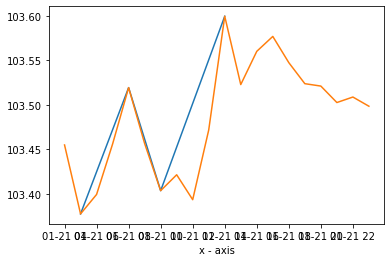

In [46]:
import matplotlib. pyplot as plt
start_obs=110
end_obs=130
results2plot=results.iloc[start_obs:end_obs]
plt.plot(results2plot["turning_point"].dropna().index, results2plot["turning_point"].dropna(), label = "turning point")
plt.plot(results2plot.index, results2plot["midPrice"], label = "Price")
# plt.plot(results2plot.index[0:obs], results2plot["PL"].head(obs), label = "PL")
# plt.plot(results2plot.index[0:obs], results2plot["PH"].head(obs), label = "PH")
plt.xlabel('x - axis')

In [47]:
dataset.iloc[start_obs:end_obs]

,index,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R
time,,,,,,,,,,,,,
2021-01-21 04:00:00,110,103.454770,OS-,103.454770,-0.000659,pl,NaN,103.895750,103.454770,normal,NaN,NaN,NaN
2021-01-21 05:00:00,111,103.377245,OS-,103.377245,-0.000749,pl,103.377245,103.895750,103.377245,normal,NaN,NaN,NaN
2021-01-21 06:00:00,112,103.399137,,NaN,0.000212,,NaN,103.895750,103.895750,normal,NaN,NaN,NaN
2021-01-21 07:00:00,113,103.455875,,NaN,0.000549,,NaN,103.895750,103.895750,normal,NaN,NaN,NaN
2021-01-21 08:00:00,114,103.519231,DC+,103.519231,0.000612,ph,103.519231,103.519231,103.895750,normal,43.0,4.002390,0.000093
2021-01-21 09:00:00,115,103.456405,OS+,NaN,-0.000607,,NaN,103.895750,103.895750,normal,NaN,NaN,NaN
2021-01-21 10:00:00,116,103.403375,DC-,103.403375,-0.000513,pl,103.403375,103.895750,103.403375,normal,2.0,1.119177,0.000560
2021-01-21 11:00:00,117,103.421256,OS-,NaN,0.000173,,NaN,103.895750,103.895750,normal,NaN,NaN,NaN
2021-01-21 12:00:00,118,103.393250,,103.393250,-0.000271,pl,NaN,103.895750,103.393250,abnormal,NaN,NaN,NaN


# TRADING STRATEGY

## JC1

In [48]:
[sum(results["TMV"]>=2), sum(results["TMV"]<=2)]

[95, 344]

In [49]:
results["Event"].value_counts()

       2986
OS+     892
OS-     627
DC-     220
DC+     220
Name: Event, dtype: int64

In [50]:
results["ret"].describe()

count    4945.000000
mean        0.000019
std         0.000608
min        -0.004289
25%        -0.000252
50%         0.000021
75%         0.000311
max         0.009670
Name: ret, dtype: float64

In [51]:
results=results[results["Event"]!=""]
results

,index,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R,midPrice
time,,,,,,,,,,,,,,
2021-01-14 02:00:00,12,104.032232,OS+,104.032232,0.001695,ph,NaN,104.032232,103.895750,normal,NaN,NaN,NaN,104.032232
2021-01-14 03:00:00,13,104.059798,OS+,104.059798,0.000265,ph,NaN,104.059798,103.895750,normal,NaN,NaN,NaN,104.059798
2021-01-14 13:00:00,23,104.097702,OS+,104.097702,0.000771,ph,104.097702,104.097702,103.895750,abnormal,NaN,NaN,NaN,104.097702
2021-01-14 15:00:00,25,103.953500,DC-,103.953500,-0.000908,pl,103.953500,103.895750,103.953500,abnormal,NaN,NaN,NaN,103.953500
2021-01-14 16:00:00,26,103.739589,OS-,103.739589,-0.002058,pl,NaN,103.895750,103.739589,abnormal,NaN,NaN,NaN,103.739589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29 14:00:00,4935,113.832124,OS+,113.832124,0.001308,ph,113.832124,113.832124,103.895750,abnormal,NaN,NaN,NaN,113.832124
2021-11-29 15:00:00,4936,113.712170,DC-,113.712170,-0.001054,pl,113.712170,103.895750,113.712170,normal,8.0,2.449228,0.000306,113.712170
2021-11-29 16:00:00,4937,113.707232,OS-,113.707232,-0.000043,pl,NaN,103.895750,113.707232,normal,NaN,NaN,NaN,113.707232


In [52]:
results[results["TMV"].abs()>=2]["Event"].value_counts()

DC-    51
DC+    44
Name: Event, dtype: int64

In [53]:
results=results.set_index("index")

In [9]:
def JC1(results_bkp, tmv_th=2, trade_size=1):
    
    results=results_bkp.copy()
    initial_regime=results.head(1)["regime"].values[0]
    initial_regime
    results["total_position"]=0
    results["trade"]=0
    results["trend"]=""
    results["direction"]=""
    # results["price_c"]=np.nan
    # results["price_o"]=np.nan
    results["TMV"].fillna(0, inplace=True)
    trend=""
    tot_position=0
    regime=initial_regime

    for row in results.iterrows():
        t=row[1]
        t_index=row[0]

        profit=0

        #trend detection
        if t["Event"]=="DC+":
                trend="up"
        elif t["Event"]=="DC-":
                trend="down"      

        results.loc[t_index,"trend"]=trend

        #regime change detection
        if t["regime"]!=regime:
            regime=t["regime"]
            #closing position when regime changes
            if tot_position!=0:
                results.loc[t_index,"direction"]="close regime change"
                results.loc[t_index,"trade"]=-tot_position
                tot_position-=tot_position
                results.loc[t_index,"total_position"]=tot_position
                price_c=t["Price"]
    #             results.loc[t_index,"price_c"]=price_c
    #             results.loc[t_index,"price_o"]=price_o
                profit=(price_c-price_o)*trade_size 
                results.loc[t_index,"trade_profit"]=profit
                results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                del price_c, price_o, profit
                continue            

        #regime detection
        regime=t["regime"]                     

        #normal regime (contrarian)  
        if regime=="normal":

            if trend=="up": #current trend (previous was down)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]="close contrarian"
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit
                        continue

                #open contrarian position
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"                
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
    #                     results.loc[t_index,"price_o"]=price_o
                        continue          


            elif trend=="down": #current trend (previous was up)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]="close contrarian"
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit
                        continue

                #open contrarian position 
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
    #                     results.loc[t_index,"price_o"]=price_o
                        continue

        #abnormal regime (trend following)  
        if regime=="abnormal":

            if trend=="up": #current trend (previous was down)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]="close trend following"
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit
                        continue

                #open trend following position
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open trend following"                
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
    #                     results.loc[t_index,"price_o"]=price_o
                        continue            


            elif trend=="down": #current trend (previous was up)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]="close trend following"
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit
                        continue

                #open trend following
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open trend following"
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
    #                     results.loc[t_index,"price_o"]=price_o
                        continue
    return results

In [55]:
results=JC1(results)
results["trade_profit"].sum()

2.228550782554578

In [56]:
results.groupby(["regime","direction"])["trade_profit"].count()

regime    direction            
abnormal                            0
          close regime change      19
          close trend following     7
          open trend following      0
normal                              0
          close contrarian         43
          close regime change      16
          open contrarian           0
Name: trade_profit, dtype: int64

In [57]:
results.groupby(["regime","direction"])["trade_profit"].mean()

regime    direction            
abnormal                                NaN
          close regime change      0.020120
          close trend following   -0.052324
          open trend following          NaN
normal                                  NaN
          close contrarian         0.031919
          close regime change      0.052500
          open contrarian               NaN
Name: trade_profit, dtype: float64

In [58]:
results.groupby(["regime","direction"])["trade_profit"].sum()

regime    direction            
abnormal                           0.000000
          close regime change      0.382284
          close trend following   -0.366269
          open trend following     0.000000
normal                             0.000000
          close contrarian         1.372534
          close regime change      0.840003
          open contrarian          0.000000
Name: trade_profit, dtype: float64

<AxesSubplot:xlabel='index'>

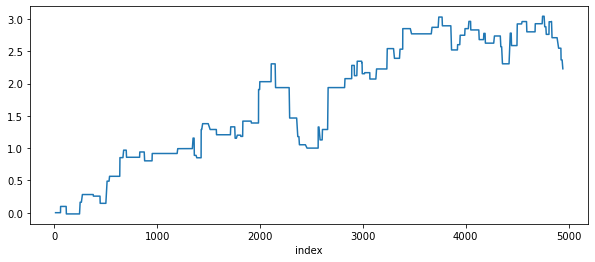

In [59]:
results["trade_profit"].fillna(0).cumsum().plot(figsize=(10,4))

<AxesSubplot:xlabel='index'>

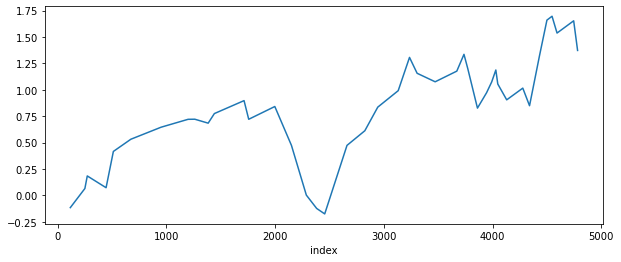

In [61]:
results[results["direction"]=="close contrarian"]["trade_profit"].fillna(0).cumsum().plot(figsize=(10,4))

<AxesSubplot:xlabel='index'>

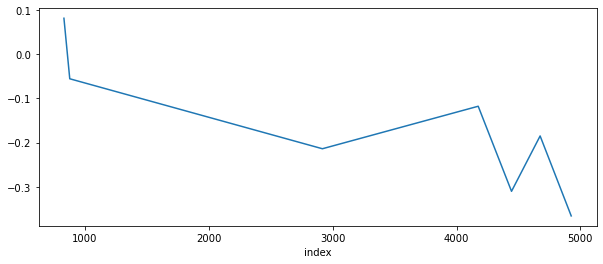

In [62]:
results[results["direction"]=="close trend following"]["trade_profit"].fillna(0).cumsum().plot(figsize=(10,4))

<AxesSubplot:>

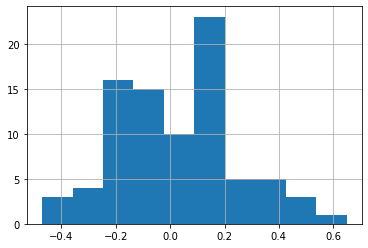

In [63]:
results["trade_profit"].hist(bins=10)

<AxesSubplot:>

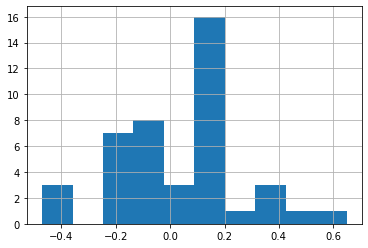

In [64]:
results[results["direction"]=="close contrarian"]["trade_profit"].hist(bins=10)

## JC1-no_regime_close_only_contrarian

In [10]:
def JC1_no_regime_close_only_contrarian(results_bkp, tmv_th=2, trade_size=1):
    
    results=results_bkp.copy()
    initial_regime=results.head(1)["regime"].values[0]
    initial_regime
    results["total_position"]=0
    results["trade"]=0
    results["trend"]=""
    results["direction"]=""
    # results["price_c"]=np.nan
    # results["price_o"]=np.nan
    results["TMV"].fillna(0, inplace=True)
    trend=""
    tot_position=0
    regime=initial_regime

    for row in results.iterrows():
        t=row[1]
        t_index=row[0]

        profit=0

        #trend detection
        if t["Event"]=="DC+":
                trend="up"
        elif t["Event"]=="DC-":
                trend="down"      

        results.loc[t_index,"trend"]=trend

        #regime change detection
        if t["regime"]!=regime:
            regime=t["regime"]
            #closing position when regime changes
    #         if tot_position!=0:
    #             results.loc[t_index,"direction"]="close regime change"
    #             results.loc[t_index,"trade"]=-tot_position
    #             tot_position-=tot_position
    #             results.loc[t_index,"total_position"]=tot_position
    #             price_c=t["Price"]
    # #             results.loc[t_index,"price_c"]=price_c
    # #             results.loc[t_index,"price_o"]=price_o
    #             profit=(price_c-price_o)*trade_size 
    #             results.loc[t_index,"trade_profit"]=profit
    #             results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
    #             del price_c, price_o, profit
    #             continue            

        #regime detection
        regime=t["regime"]                     

        #normal regime (contrarian)  
        if regime=="normal":

            if trend=="up": #current trend (previous was down)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open contrarian position
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"                
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open contrarian"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open contrarian in {} at {}".format(t_index, t["Price"]))
                        continue          


            elif trend=="down": #current trend (previous was up)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open contrarian position 
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open contrarian"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open trend in {} at {}".format(t_index, t["Price"]))
                        continue

        #abnormal regime (trend following)  
        if regime=="abnormal":

            if trend=="up": #current trend (previous was down)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

#                 #open trend following position
#                 if tot_position==0:
#                     if t["TMV"]>=tmv_th:
#                         results.loc[t_index,"direction"]="open trend following"                
#                         results.loc[t_index,"trade"]=-trade_size
#                         tot_position-=trade_size
#                         results.loc[t_index,"total_position"]=tot_position
#                         price_o=t["Price"]
#                         trade_opened_for="open trend following"
#     #                     results.loc[t_index,"price_o"]=price_o
#     #                     print("open trend in {} at {}".format(t_index, t["Price"]))
#                         continue            


            elif trend=="down": #current trend (previous was up)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

#                 #open trend following
#                 if tot_position==0:
#                     if t["TMV"]>=tmv_th:
#                         results.loc[t_index,"direction"]="open trend following"
#                         results.loc[t_index,"trade"]=+trade_size
#                         tot_position+=trade_size
#                         results.loc[t_index,"total_position"]=tot_position
#                         price_o=t["Price"]
#                         trade_opened_for="open trend following"
#     #                     results.loc[t_index,"price_o"]=price_o
#     #                     print("open contrarian in {} at {}".format(t_index, t["Price"]))
#                         continue

    return results

## JC1-no_regime_close

In [205]:
def JC1_no_regime_close(results_bkp, tmv_th=2, trade_size=1):
    
    results=results_bkp.copy()
    initial_regime=results.head(1)["regime"].values[0]
    initial_regime
    results["total_position"]=0
    results["trade"]=0
    results["trend"]=""
    results["direction"]=""
    # results["price_c"]=np.nan
    # results["price_o"]=np.nan
    results["TMV"].fillna(0, inplace=True)
    trend=""
    tot_position=0
    regime=initial_regime

    for row in results.iterrows():
        t=row[1]
        t_index=row[0]

        profit=0

        #trend detection
        if t["Event"]=="DC+":
                trend="up"
        elif t["Event"]=="DC-":
                trend="down"      

        results.loc[t_index,"trend"]=trend

        #regime change detection
        if t["regime"]!=regime:
            regime=t["regime"]
            #closing position when regime changes
    #         if tot_position!=0:
    #             results.loc[t_index,"direction"]="close regime change"
    #             results.loc[t_index,"trade"]=-tot_position
    #             tot_position-=tot_position
    #             results.loc[t_index,"total_position"]=tot_position
    #             price_c=t["Price"]
    # #             results.loc[t_index,"price_c"]=price_c
    # #             results.loc[t_index,"price_o"]=price_o
    #             profit=(price_c-price_o)*trade_size 
    #             results.loc[t_index,"trade_profit"]=profit
    #             results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
    #             del price_c, price_o, profit
    #             continue            

        #regime detection
        regime=t["regime"]                     

        #normal regime (contrarian)  
        if regime=="normal":

            if trend=="up": #current trend (previous was down)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open contrarian position
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"                
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open contrarian"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open contrarian in {} at {}".format(t_index, t["Price"]))
                        continue          


            elif trend=="down": #current trend (previous was up)

                #close contration position
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open contrarian position 
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open contrarian"
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open contrarian"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open trend in {} at {}".format(t_index, t["Price"]))
                        continue

        #abnormal regime (trend following)  
        if regime=="abnormal":

            if trend=="up": #current trend (previous was down)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC+"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open trend following position
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open trend following"                
                        results.loc[t_index,"trade"]=-trade_size
                        tot_position-=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open trend following"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open trend in {} at {}".format(t_index, t["Price"]))
                        continue            


            elif trend=="down": #current trend (previous was up)

                #close trend following
                if tot_position!=0:
                    if t["Event"] in ["DC-"]:
                        results.loc[t_index,"direction"]=trade_opened_for.replace("open", "close")
                        results.loc[t_index,"trade"]=-tot_position
                        tot_position-=tot_position
                        results.loc[t_index,"total_position"]=tot_position
                        price_c=t["Price"]
    #                     results.loc[t_index,"price_c"]=price_c
    #                     results.loc[t_index,"price_o"]=price_o
                        profit=(price_c-price_o)*trade_size
                        results.loc[t_index,"trade_profit"]=profit
                        results.loc[t_index,"trade_returns"]=(price_c-price_o)/price_o
                        del price_c, price_o, profit, trade_opened_for
                        continue

                #open trend following
                if tot_position==0:
                    if t["TMV"]>=tmv_th:
                        results.loc[t_index,"direction"]="open trend following"
                        results.loc[t_index,"trade"]=+trade_size
                        tot_position+=trade_size
                        results.loc[t_index,"total_position"]=tot_position
                        price_o=t["Price"]
                        trade_opened_for="open trend following"
    #                     results.loc[t_index,"price_o"]=price_o
    #                     print("open contrarian in {} at {}".format(t_index, t["Price"]))
                        continue

    return results

# UNIVARIATE TRADING STRATEGY HYPERPARAMETER CALIBRATION

In [290]:
# directional change threshold
directional_change_threshold_list=[0.001/100, #43% of time 1H data
                                   0.0175/100, #30% of time 1H data
                                   0.02/100,
                                   0.025/100, #26% of time 1H data
                                   0.05/100,
                                   0.1/100]  #9% of time 1H data
                                   
#TMV
tmv_threshold_list=[0.5, 1, 1.5, 2, 2.5, 3]

assets_list = [f.split(".")[0] for f in listdir("./data/") if isfile(join("./data/", f)) and f.endswith(".csv")]
assets_list.remove("USDCNY")

exptime=len(directional_change_threshold_list)*len(tmv_threshold_list)*20/60
print("{} minutes".format(exptime))

12.0 minutes


In [291]:
strategy="JC1_no_regime_close_only_contrarian"

back_testing_results = pd.DataFrame()
MS_estimates=dict()
MS_parameters=dict()

i=0
for asset_name in tqdm(assets_list):
    
    print("###################################\n{}".format(asset_name))
    
    ################################################
    #asset reading
    asset=data_loading(asset_name, cwd)
    asset=data_cleaning(asset, "1H")
    
#     asset=asset.iloc[:20]
    
    asset=asset.mean(axis=1)
    asset_r=asset.pct_change(1).dropna()
    
    ################################################    
    #best MS model serch (using BIC)
    k_regimes=[2]
    order=[1,2,3]
    switching_ar=[True, False]
    switching_variance=[True, False]

    BIC=[]
    for k in k_regimes:
        for o in order:    
            print("order {}".format(o))
            for s_ar in switching_ar:
                print("switching AR {}".format(s_ar))
                for s_variance in switching_variance:
                    if o==0 & s_ar==True:
                        continue
                    print("switching variance {}".format(s_variance))   
                    BIC_tmp=pd.DataFrame()
                    mod_hamilton = sm.tsa.MarkovAutoregression(asset_r, k_regimes=k, order=o, switching_ar=s_ar, switching_variance=s_variance, trend='c')
                    res_hamilton = mod_hamilton.fit()
                    BIC_tmp.loc[0,"k"]=k
                    BIC_tmp.loc[0,"ar_order"]=o
                    BIC_tmp.loc[0,"s_ar"]=s_ar
                    BIC_tmp.loc[0,"s_var"]=s_variance
                    BIC_tmp.loc[0,"BIC"]=res_hamilton.bic
                    BIC.append(BIC_tmp)

    ################################################
    # best model (minimum BIC) run
    BIC=pd.concat(BIC, axis=0).set_index(["k","ar_order","s_ar","s_var"])
    params=list(BIC.idxmin()[0])
    mod_hamilton = sm.tsa.MarkovAutoregression(asset_r, k_regimes=int(params[0]), order=int(params[1]), switching_ar=params[2], switching_variance=params[3], trend='c')
    res_hamilton = mod_hamilton.fit()    

    MS_estimates[asset_name] = res_hamilton
    MS_parameters[asset_name] = params

    print(res_hamilton.summary())

    print(res_hamilton.expected_durations)

    normal_regime=pd.Series(res_hamilton.expected_durations).idxmax()
    abnormal_regime=pd.Series(res_hamilton.expected_durations).idxmin()
    print("normal regime is {}".format(normal_regime))

    regimes=res_hamilton.smoothed_marginal_probabilities
    regimes.loc[regimes[normal_regime]>0.5,"regime"]="normal"
    regimes=regimes.fillna("abnormal")
       
    ################################################
    ### TRADING STRATEGY BACK TEST
    
    for d in tqdm(directional_change_threshold_list):
        for tmv_th in tqdm(tmv_threshold_list):
            i+=1
            back_testing_results_tmp=pd.DataFrame()

            events=generate(asset, d)

            events=pd.merge(events, regimes["regime"].reset_index(), how="inner", left_on="time", right_on="Timestamp").drop(columns="Timestamp")

            dataset=TMV_R(events, d)

            results=pd.merge(dataset,
                         asset.to_frame(),
                         how="left", right_index=True, left_index=True).drop(columns=0)
            results.loc[results.index[0],"turning_point"]=results.loc[results.index[0],"Price"]
            results=results.set_index("index")

            initial_regime=results.head(1)["regime"].values[0]

            ##########################################
            # STRATEGY SELECTIONL
            if strategy=="JC1":
                strategy_results=JC1(results, tmv_th, trade_size=1)
            elif strategy=="JC1_no_regime_close":
                strategy_results=JC1_no_regime_close(results, tmv_th, trade_size=1)
            elif strategy=="JC1_no_regime_close_only_contrarian":
                strategy_results=JC1_no_regime_close_only_contrarian(results, tmv_th, trade_size=1)
            ##########################################


            ##################################
            # strategy metrics

            try:
                
                min_wealth=strategy_results["trade_returns"].fillna(0).cumsum().min()
                max_wealth=strategy_results["trade_returns"].fillna(0).cumsum().max()
                maxdrawdown=strategy_results["trade_returns"].fillna(0).min()
                maxgain=strategy_results["trade_returns"].fillna(0).max() 
                
                VaR_hist=strategy_results["trade_returns"].dropna().quantile(q=0.05)
                CVaR_hist=strategy_results[strategy_results.loc[:,"trade_returns"]<=VaR_hist]["trade_returns"].mean(), #expected shortfall or CVaR 
                
                total_trade_returns=strategy_results["trade_returns"].sum()
                total_mean_trade_returns=strategy_results["trade_returns"].mean()
                trade_returns_sd=strategy_results["trade_returns"].std()
                trade_returns_SR=strategy_results["trade_returns"].mean()/strategy_results["trade_returns"].std()

#                 if strategy=="JC1":
#                     back_testing_results_tmp = pd.DataFrame(
#                         {
#                         "strategy": strategy,
#                         "asset": asset_name,
#                         "index": i,  
#                         "dc_threshold": d,
#                         "TMV_threshold": tmv_th,
#                         "trade_returns": strategy_results["trade_returns"].sum(),

#                         "#trades_normal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["normal","close regime change"]],
#                         "#trades_abnormal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["abnormal","close regime change"]],
#                         "#trades_normal_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["normal","close contrarian"]],
#                         "#trades_abnormal_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["abnormal","close trend following"]],

#                         "mean_profit_normal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returns"].mean().loc[idx["normal","close regime change"]],
#                         "mean_profit_abnormal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returnsrofit"].mean().loc[idx["abnormal","close regime change"]],
#                         "mean_profit_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].mean().loc[idx["normal","close contrarian"]],
#                         "mean_profit_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].mean().loc[idx["abnormal","close trend following"]],

#                         "total_profit_normal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["normal","close regime change"]],
#                         "total_profit_abnormal_close_regime": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["abnormal","close regime change"]],
#                         "total_profit_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["normal","close contrarian"]],
#                         "total_profit_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["abnormal","close trend following"]],
#                         "min_wealth": min_wealth,
#                         "max_wealth": max_wealth,
#                         "maxdrawdown": maxdrawdown,
#                         "maxgain": maxgain,
#                         "VaR_hist": VaR_hist,
#                         "CVaR_hist": CVaR_hist
#                         },
#                         index=[i]
#                     )

#                     back_testing_results = pd.concat([back_testing_results, back_testing_results_tmp])     

#                 if strategy=="JC1_no_regime_close":
#                     back_testing_results_tmp = pd.DataFrame(
#                         {
#                         "strategy": strategy,
#                         "asset": asset_name,
#                         "index": i,  
#                         "dc_threshold": d,
#                         "TMV_threshold": tmv_th,
#                         "trade_returns": strategy_results["trade_returns"].sum(),

#                         "#trades_normal_close_regime": np.nan,
#                         "#trades_abnormal_close_regime": np.nan,
#                         "#trades_normal_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["normal","close contrarian"]],
#                         "#trades_abnormal_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].count().loc[idx["abnormal","close trend following"]],

#                         "mean_trade_returns_normal_close_regime": np.nan,
#                         "mean_trade_returns_abnormal_close_regime": np.nan,
#                         "mean_trade_returns_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].mean().loc[idx["normal","close contrarian"]],
#                         "mean_trade_returns_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].mean().loc[idx["abnormal","close trend following"]],

#                         "total_trade_returns_normal_close_regime": np.nan,
#                         "total_trade_returns_abnormal_close_regime": np.nan,
#                         "total_trade_returns_contrarian": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["normal","close contrarian"]],
#                         "total_trade_returns_trend_following": strategy_results.groupby(["regime","direction"])["trade_returns"].sum().loc[idx["abnormal","close trend following"]],
#                         "min_wealth": min_wealth,
#                         "max_wealth": max_wealth,
#                         "maxdrawdown": maxdrawdown,
#                         "maxgain": maxgain,
#                         "VaR_hist": VaR_hist,
#                         "CVaR_hist": CVaR_hist
#                         },
#                         index=[i]
#                     )

                if strategy=="JC1_no_regime_close_only_contrarian":
                    
                    back_testing_results_tmp = pd.DataFrame(
                        {
                        "strategy": strategy,
                        "asset": asset_name,
                        "index": i,  
                        "dc_threshold": d,
                        "TMV_threshold": tmv_th,
                        "total_trade_returns": total_trade_returns,
                        "trade_returns_mean": total_mean_trade_returns,
                        "trade_returns_sd": trade_returns_sd,
                        "trade_returns_SR": trade_returns_SR,

                        "#trades_normal_close_regime": np.nan,
                        "#trades_abnormal_close_regime": np.nan,
                        "#trades_normal_contrarian": strategy_results.groupby(["direction"])["trade_returns"].count().loc["close contrarian"],
                        "#trades_abnormal_trend_following": np.nan,

                        "mean_trade_returns_normal_close_regime": np.nan,
                        "mean_trade_returnsabnormal_close_regime": np.nan,
                        "mean_trade_returns_contrarian": strategy_results.groupby(["direction"])["trade_returns"].mean().loc["close contrarian"],
                        "mean_trade_returns_trend_following": np.nan,

                        "trade_returns_normal_close_regime": np.nan,
                        "trade_returns_abnormal_close_regime": np.nan,
                        "trade_returns_contrarian": strategy_results.groupby(["direction"])["trade_returns"].sum().loc["close contrarian"],
                        "trade_returns_trend_following": np.nan,
                        "min_wealth": min_wealth,
                        "max_wealth": max_wealth,
                        "maxdrawdown": maxdrawdown,
                        "maxgain": maxgain,
                        "VaR_hist": VaR_hist,
                        "CVaR_hist": CVaR_hist
                        },
                        index=[i]
                    )                    
                    back_testing_results = pd.concat([back_testing_results, back_testing_results_tmp]) 
#                     print(back_testing_results_tmp)

            except:
                print("No trades")            

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

###################################
AUDUSD
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4945
Model:             MarkovAutoregression   Log Likelihood               27852.985
Date:                  Wed, 12 Jan 2022   AIC                         -55689.969
Time:                          16:55:35   BIC                         -55637.920
Sample:                               0   HQIC                        -55671.717
                                 - 4945   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:17<01:29, 17.98s/it]

 33%|████████████████████████████                                                        | 2/6 [00:35<01:11, 17.81s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:53<00:53, 17.83s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:11<00:35, 17.74s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:30<00:18, 18.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:47<00:00, 17.96s/it]

 17%|█████████████▊            

###################################
EURGBP
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4945
Model:             MarkovAutoregression   Log Likelihood               30678.835
Date:                  Wed, 12 Jan 2022   AIC                         -61341.670
Time:                          17:08:38   BIC                         -61289.621
Sample:                               0   HQIC                        -61323.418
                                 - 4945   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:27<02:18, 27.67s/it]

 33%|████████████████████████████                                                        | 2/6 [00:55<01:49, 27.49s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:17<01:16, 25.35s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:37<00:46, 23.05s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:55<00:21, 21.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:14<00:00, 22.39s/it]

 17%|█████████████▊            

###################################
EURUSD
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 5155
Model:             MarkovAutoregression   Log Likelihood               31764.477
Date:                  Wed, 12 Jan 2022   AIC                         -63512.955
Time:                          17:22:44   BIC                         -63460.573
Sample:                               0   HQIC                        -63494.624
                                 - 5155   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:20<01:40, 20.19s/it]

 33%|████████████████████████████                                                        | 2/6 [00:42<01:24, 21.15s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:15, 25.04s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:33<00:47, 23.64s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:01<00:25, 25.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:37<00:00, 26.31s/it]

 17%|█████████████▊            

###################################
GBPUSD
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4944
Model:             MarkovAutoregression   Log Likelihood               29333.229
Date:                  Wed, 12 Jan 2022   AIC                         -58652.458
Time:                          17:39:10   BIC                         -58606.917
Sample:                               0   HQIC                        -58636.488
                                 - 4944   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:16<01:23, 16.76s/it]

 33%|████████████████████████████                                                        | 2/6 [00:33<01:06, 16.67s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:50<00:50, 16.95s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:07<00:33, 16.79s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:24<00:16, 16.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:41<00:00, 16.85s/it]

 17%|█████████████▊            

###################################
NZDCHF
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4847
Model:             MarkovAutoregression   Log Likelihood               27690.055
Date:                  Wed, 12 Jan 2022   AIC                         -55366.109
Time:                          17:51:32   BIC                         -55320.707
Sample:                               0   HQIC                        -55350.171
                                 - 4847   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:16<01:24, 16.89s/it]

 33%|████████████████████████████                                                        | 2/6 [00:34<01:08, 17.21s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:51<00:51, 17.09s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:08<00:34, 17.08s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:25<00:17, 17.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:42<00:00, 17.06s/it]

 17%|█████████████▊            

###################################
NZDJPY
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4926
Model:             MarkovAutoregression   Log Likelihood               27682.489
Date:                  Wed, 12 Jan 2022   AIC                         -55350.977
Time:                          18:04:39   BIC                         -55305.461
Sample:                               0   HQIC                        -55335.013
                                 - 4926   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:18<01:32, 18.41s/it]

 33%|████████████████████████████                                                        | 2/6 [00:36<01:12, 18.07s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:54<00:54, 18.02s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:11<00:35, 17.90s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:30<00:17, 17.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.37s/it]

 17%|█████████████▊            

###################################
USDCAD
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4944
Model:             MarkovAutoregression   Log Likelihood               29344.507
Date:                  Wed, 12 Jan 2022   AIC                         -58673.013
Time:                          18:19:37   BIC                         -58620.966
Sample:                               0   HQIC                        -58654.761
                                 - 4944   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:18<01:32, 18.59s/it]

 33%|████████████████████████████                                                        | 2/6 [00:37<01:14, 18.63s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:55<00:55, 18.62s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:14<00:36, 18.43s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:31<00:18, 18.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.48s/it]

 17%|█████████████▊            

###################################
USDCHF
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4938
Model:             MarkovAutoregression   Log Likelihood               29846.183
Date:                  Wed, 12 Jan 2022   AIC                         -59676.367
Time:                          18:33:08   BIC                         -59624.329
Sample:                               0   HQIC                        -59658.117
                                 - 4938   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:28<02:20, 28.06s/it]

 33%|████████████████████████████                                                        | 2/6 [00:54<01:48, 27.04s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:13<01:09, 23.28s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:31<00:42, 21.16s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:51<00:20, 20.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:12<00:00, 22.06s/it]

 17%|█████████████▊            

###################################
USDJPY
order 1
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 2
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
order 3
switching AR True
switching variance True
switching variance False
switching AR False
switching variance True
switching variance False
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 4945
Model:             MarkovAutoregression   Log Likelihood               30364.438
Date:                  Wed, 12 Jan 2022   AIC                         -60712.877
Time:                          18:47:22   BIC                         -60660.828
Sample:                               0   HQIC                        -60694.624
                                 - 4945   


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:18<01:30, 18.08s/it]

 33%|████████████████████████████                                                        | 2/6 [00:35<01:11, 17.89s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [00:53<00:53, 17.86s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:11<00:35, 17.81s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:29<00:17, 17.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:47<00:00, 17.92s/it]

 17%|█████████████▊            

In [289]:
back_testing_results

,strategy,asset,index,dc_threshold,TMV_threshold,total_trade_returns,trade_returns_mean,trade_returns_sd,trade_returns_SR,#trades_normal_close_regime,#trades_abnormal_close_regime,#trades_normal_contrarian,#trades_abnormal_trend_following,mean_trade_returns_normal_close_regime,mean_trade_returnsabnormal_close_regime,mean_trade_returns_contrarian,mean_trade_returns_trend_following,trade_returns_normal_close_regime,trade_returns_abnormal_close_regime,trade_returns_contrarian,trade_returns_trend_following,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
1,JC1_no_regime_close_only_contrarian,AUDUSD,1,0.000010,0.5,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
2,JC1_no_regime_close_only_contrarian,AUDUSD,2,0.000010,1.0,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
3,JC1_no_regime_close_only_contrarian,AUDUSD,3,0.000010,1.5,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
4,JC1_no_regime_close_only_contrarian,AUDUSD,4,0.000010,2.0,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
5,JC1_no_regime_close_only_contrarian,AUDUSD,5,0.000010,2.5,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
6,JC1_no_regime_close_only_contrarian,AUDUSD,6,0.000010,3.0,-0.000807,-0.000404,0.000610,-0.661248,NaN,NaN,2,NaN,NaN,NaN,-0.000404,NaN,NaN,NaN,-0.000807,NaN,-0.000807,0.000028,-0.000835,0.000028,-0.000814,-0.000835
7,JC1_no_regime_close_only_contrarian,AUDUSD,7,0.000175,0.5,0.000844,0.000422,0.001778,0.237318,NaN,NaN,2,NaN,NaN,NaN,0.000422,NaN,NaN,NaN,0.000844,NaN,0.000000,0.001679,-0.000835,0.001679,-0.000772,-0.000835
8,JC1_no_regime_close_only_contrarian,AUDUSD,8,0.000175,1.0,0.000844,0.000422,0.001778,0.237318,NaN,NaN,2,NaN,NaN,NaN,0.000422,NaN,NaN,NaN,0.000844,NaN,0.000000,0.001679,-0.000835,0.001679,-0.000772,-0.000835
9,JC1_no_regime_close_only_contrarian,AUDUSD,9,0.000175,1.5,0.000844,0.000422,0.001778,0.237318,NaN,NaN,2,NaN,NaN,NaN,0.000422,NaN,NaN,NaN,0.000844,NaN,0.000000,0.001679,-0.000835,0.001679,-0.000772,-0.000835
10,JC1_no_regime_close_only_contrarian,AUDUSD,10,0.000175,2.0,0.000844,0.000422,0.001778,0.237318,NaN,NaN,2,NaN,NaN,NaN,0.000422,NaN,NaN,NaN,0.000844,NaN,0.000000,0.001679,-0.000835,0.001679,-0.000772,-0.000835


Save the results

In [292]:
back_testing_results.to_csv("{}_backtesting.csv".format(strategy), index=False)

with open("MS_estimates.pkl", 'wb') as f:
    pickle.dump(MS_estimates, f)
    
with open("MS_parameters.pkl", 'wb') as f:
    pickle.dump(MS_parameters, f)    

Read the results

In [293]:
back_testing_results=pd.read_csv("JC1_no_regime_close_only_contrarian_backtesting.csv")
back_testing_results

,strategy,asset,index,dc_threshold,TMV_threshold,total_trade_returns,trade_returns_mean,trade_returns_sd,trade_returns_SR,#trades_normal_close_regime,#trades_abnormal_close_regime,#trades_normal_contrarian,#trades_abnormal_trend_following,mean_trade_returns_normal_close_regime,mean_trade_returnsabnormal_close_regime,mean_trade_returns_contrarian,mean_trade_returns_trend_following,trade_returns_normal_close_regime,trade_returns_abnormal_close_regime,trade_returns_contrarian,trade_returns_trend_following,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
0,JC1_no_regime_close_only_contrarian,AUDUSD,1,0.000010,0.5,0.065728,6.659321e-05,0.001551,0.042927,NaN,NaN,987,NaN,NaN,NaN,6.659321e-05,NaN,NaN,NaN,0.065728,NaN,-0.012740,0.068724,-0.011950,0.011799,-0.002706,-0.005290
1,JC1_no_regime_close_only_contrarian,AUDUSD,2,0.000010,1.0,0.065728,6.659321e-05,0.001551,0.042927,NaN,NaN,987,NaN,NaN,NaN,6.659321e-05,NaN,NaN,NaN,0.065728,NaN,-0.012740,0.068724,-0.011950,0.011799,-0.002706,-0.005290
2,JC1_no_regime_close_only_contrarian,AUDUSD,3,0.000010,1.5,0.081448,8.277202e-05,0.001467,0.056423,NaN,NaN,984,NaN,NaN,NaN,8.277202e-05,NaN,NaN,NaN,0.081448,NaN,-0.012740,0.084444,-0.011324,0.011799,-0.002560,-0.004557
3,JC1_no_regime_close_only_contrarian,AUDUSD,4,0.000010,2.0,0.090206,9.195317e-05,0.001465,0.062777,NaN,NaN,981,NaN,NaN,NaN,9.195317e-05,NaN,NaN,NaN,0.090206,NaN,-0.012740,0.093203,-0.011324,0.011799,-0.002510,-0.004524
4,JC1_no_regime_close_only_contrarian,AUDUSD,5,0.000010,2.5,0.096855,9.893263e-05,0.001456,0.067947,NaN,NaN,979,NaN,NaN,NaN,9.893263e-05,NaN,NaN,NaN,0.096855,NaN,-0.012740,0.099852,-0.011324,0.011799,-0.002505,-0.004492
5,JC1_no_regime_close_only_contrarian,AUDUSD,6,0.000010,3.0,0.082257,8.453929e-05,0.001526,0.055396,NaN,NaN,973,NaN,NaN,NaN,8.453929e-05,NaN,NaN,NaN,0.082257,NaN,-0.012740,0.085254,-0.011950,0.011799,-0.002536,-0.005001
6,JC1_no_regime_close_only_contrarian,AUDUSD,7,0.000175,0.5,0.040626,5.395221e-05,0.001719,0.031391,NaN,NaN,753,NaN,NaN,NaN,5.395221e-05,NaN,NaN,NaN,0.040626,NaN,-0.012579,0.054695,-0.011324,0.011799,-0.003276,-0.005780
7,JC1_no_regime_close_only_contrarian,AUDUSD,8,0.000175,1.0,0.044112,5.969147e-05,0.001687,0.035374,NaN,NaN,739,NaN,NaN,NaN,5.969147e-05,NaN,NaN,NaN,0.044112,NaN,-0.012551,0.058181,-0.011324,0.011799,-0.002977,-0.005485
8,JC1_no_regime_close_only_contrarian,AUDUSD,9,0.000175,1.5,0.044944,6.375009e-05,0.001711,0.037253,NaN,NaN,705,NaN,NaN,NaN,6.375009e-05,NaN,NaN,NaN,0.044944,NaN,-0.031979,0.057868,-0.011324,0.009444,-0.002885,-0.005273
9,JC1_no_regime_close_only_contrarian,AUDUSD,10,0.000175,2.0,0.051974,7.874825e-05,0.001774,0.044395,NaN,NaN,660,NaN,NaN,NaN,7.874825e-05,NaN,NaN,NaN,0.051974,NaN,-0.004186,0.069889,-0.011324,0.011799,-0.002681,-0.005557


In [6]:
with open('MS_estimates.pkl', 'rb') as f:
    MS_estimates = pickle.load(f)
MS_estimates   

with open('MS_parameters.pkl', 'rb') as f:
    MS_parameters = pickle.load(f)
MS_parameters  

{'AUDUSD': <class 'statsmodels.iolib.summary.Summary'>
 """
                          Markov Switching Model Results                         
 Dep. Variable:                        y   No. Observations:                 4945
 Model:             MarkovAutoregression   Log Likelihood               27852.985
 Date:                  Mon, 10 Jan 2022   AIC                         -55689.969
 Time:                          16:00:43   BIC                         -55637.920
 Sample:                               0   HQIC                        -55671.717
                                  - 4945                                         
 Covariance Type:                 approx                                         
                              Regime 0 parameters                              
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const       2.984e-05   1.68e-05      1.771

## STATISTICS AND VISUALIZATION

In [216]:
back_testing_results["dc_threshold"]=back_testing_results["dc_threshold"].round(6)

In [219]:
best_hp=pd.DataFrame()
for m in ["total_trade_returns"]+back_testing_results.columns[-6:].to_list():
    best_hp_tmp=back_testing_results.set_index(["dc_threshold", "TMV_threshold"]).groupby("asset")[m].idxmax()
    best_hp=pd.concat([best_hp, best_hp_tmp], axis=1)
best_hp    

,total_trade_returns,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
asset,,,,,,,
AUDUSD,"(0.000175, 0.5)","(1e-05, 0.5)","(0.000175, 0.5)","(1e-05, 0.5)","(0.000175, 0.5)","(0.000175, 0.5)","(0.000175, 0.5)"


In [220]:
best_hp_values=pd.DataFrame()
for m in ["total_trade_returns"]+back_testing_results.columns[-6:].to_list():
    best_hp_values_tmp=back_testing_results.set_index(["dc_threshold", "TMV_threshold"]).groupby("asset")[m].max()
    best_hp_values=pd.concat([best_hp_values, best_hp_values_tmp], axis=1)
best_hp_values    

,total_trade_returns,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
asset,,,,,,,
AUDUSD,0.001679,0.0,0.001679,0.0,0.001679,0.001679,0.001679


<AxesSubplot:>

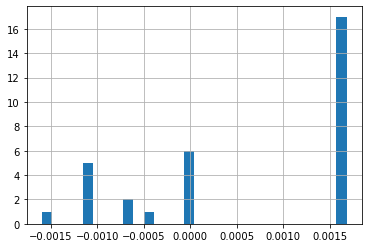

In [222]:
back_testing_results["mean_trade_returns_contrarian"].hist(bins=30)

In [223]:
back_testing_results["mean_trade_returns_contrarian"].describe()

count    32.000000
mean      0.000615
std       0.001217
min      -0.001594
25%      -0.000515
50%       0.001679
75%       0.001679
max       0.001679
Name: mean_trade_returns_contrarian, dtype: float64

In [224]:
back_testing_results["mean_trade_returns_contrarian"].nlargest(20)

7     0.001679
8     0.001679
9     0.001679
10    0.001679
11    0.001679
12    0.001679
13    0.001679
14    0.001679
15    0.001679
16    0.001679
17    0.001679
18    0.001679
19    0.001679
20    0.001679
21    0.001679
22    0.001679
23    0.001679
1     0.000028
2     0.000028
3     0.000028
Name: mean_trade_returns_contrarian, dtype: float64

In [226]:
back_testing_results.sort_values(by="total_trade_returns", ascending=False)

,strategy,asset,index,dc_threshold,TMV_threshold,total_trade_returns,total_mean_trade_returns,#trades_normal_close_regime,#trades_abnormal_close_regime,#trades_normal_contrarian,#trades_abnormal_trend_following,mean_trade_returns_normal_close_regime,mean_trade_returnsabnormal_close_regime,mean_trade_returns_contrarian,mean_trade_returns_trend_following,trade_returns_normal_close_regime,trade_returns_abnormal_close_regime,trade_returns_contrarian,trade_returns_trend_following,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
17,JC1_no_regime_close_only_contrarian,AUDUSD,17,0.000200,2.5,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
10,JC1_no_regime_close_only_contrarian,AUDUSD,10,0.000175,2.0,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
16,JC1_no_regime_close_only_contrarian,AUDUSD,16,0.000200,2.0,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
15,JC1_no_regime_close_only_contrarian,AUDUSD,15,0.000200,1.5,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
14,JC1_no_regime_close_only_contrarian,AUDUSD,14,0.000200,1.0,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
13,JC1_no_regime_close_only_contrarian,AUDUSD,13,0.000200,0.5,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
12,JC1_no_regime_close_only_contrarian,AUDUSD,12,0.000175,3.0,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
11,JC1_no_regime_close_only_contrarian,AUDUSD,11,0.000175,2.5,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
9,JC1_no_regime_close_only_contrarian,AUDUSD,9,0.000175,1.5,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679
18,JC1_no_regime_close_only_contrarian,AUDUSD,18,0.000200,3.0,0.001679,0.001679,NaN,NaN,1,NaN,NaN,NaN,0.001679,NaN,NaN,NaN,0.001679,NaN,0.000000,0.001679,0.000000,0.001679,0.001679,0.001679


In [258]:
a=JC1_no_regime_close_only_contrarian(results, tmv_th, trade_size=1)
a

,Price,Event,DC_price,ret,PL/PH,turning_point,PH,PL,regime,T,TMV,R,midPrice,total_position,trade,trend,direction,trade_profit,trade_returns
index,,,,,,,,,,,,,,,,,,,
0,1.228915,OS+,1.228915,0.000389,ph,1.228915,1.228915,1.227976,normal,NaN,0.000000,NaN,1.228915,0,0,,,NaN,NaN
1,1.229148,OS+,1.229148,0.000190,ph,1.229148,1.229148,1.227976,normal,NaN,0.000000,NaN,1.229148,0,0,,,NaN,NaN
2,1.228951,,NaN,-0.000161,,NaN,1.227976,1.227976,normal,NaN,0.000000,NaN,1.228951,0,0,,,NaN,NaN
3,1.228307,DC-,1.228307,-0.000524,pl,1.228307,1.227976,1.228307,normal,NaN,0.000000,NaN,1.228307,0,0,down,,NaN,NaN
4,1.228825,DC+,1.228825,0.000422,ph,1.228825,1.228825,1.227976,normal,1.0,2.411264,0.000422,1.228825,1,1,up,open contrarian,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,1.127020,OS+,NaN,-0.000063,,NaN,1.227976,1.227976,abnormal,NaN,0.000000,NaN,1.127020,0,0,up,,NaN,NaN
5151,1.127925,OS+,1.127925,0.000803,ph,NaN,1.127925,1.227976,normal,NaN,0.000000,NaN,1.127925,0,0,up,,NaN,NaN
5152,1.128602,OS+,1.128602,0.000600,ph,NaN,1.128602,1.227976,normal,NaN,0.000000,NaN,1.128602,0,0,up,,NaN,NaN


<AxesSubplot:>

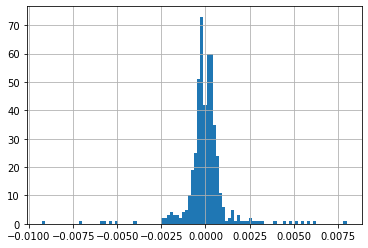

In [269]:
a["trade_profit"].dropna().hist(bins=100)

t=0

A1 (VaR)
t=1
A1, A2 (VAR)

t=4
A2 (Var)

t=5
A1,A2,A3 (VaR)

t=6
potential trades: A1, A2, A3

Trade-size/Portfolio choice module
Risk-Parity    
VaR parametric OK!
C-VaR parametric OK!
C-VaR (historical data/not parametric)     -> Rockafeller-Uryasev

# MULTIVARIATE  (PORTFOLIOS OF ASSETS) STRATEGY BACK-TESTING

## BEST HYPERPARAMETERS CHOICE

1. best total trade returns
2. best VaR_hist
3. best SR trade returns
3. best total trade returns + CVaR/VaR constrain

In [294]:
best_hp=pd.DataFrame()
for m in ["total_trade_returns"]+back_testing_results.columns[-6:].to_list():
    best_hp_tmp=back_testing_results.set_index(["dc_threshold", "TMV_threshold"]).groupby("asset")[m].idxmax()
    best_hp=pd.concat([best_hp, best_hp_tmp], axis=1)
best_hp    

,total_trade_returns,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
asset,,,,,,,
AUDUSD,"(1e-05, 2.5)","(0.00025, 2.0)","(1e-05, 2.5)","(0.00017500000000000005, 2.5)","(0.0005, 0.5)","(1e-05, 2.5)","(1e-05, 2.5)"
EURGBP,"(1e-05, 1.5)","(0.001, 1.0)","(1e-05, 1.5)","(0.001, 1.5)","(1e-05, 0.5)","(0.00025, 3.0)","(1e-05, 1.5)"
EURUSD,"(0.001, 2.5)","(0.00025, 3.0)","(1e-05, 2.0)","(0.00025, 2.5)","(0.0005, 0.5)","(1e-05, 2.5)","(1e-05, 0.5)"
GBPUSD,"(0.00017500000000000005, 3.0)","(0.00017500000000000005, 3.0)","(0.001, 1.5)","(0.0005, 2.0)","(1e-05, 0.5)","(1e-05, 1.5)","(1e-05, 1.5)"
NZDCHF,"(1e-05, 3.0)","(0.0005, 3.0)","(1e-05, 3.0)","(0.001, 2.0)","(0.0005, 0.5)","(0.0005, 3.0)","(0.0005, 3.0)"
NZDJPY,"(1e-05, 1.5)","(0.0005, 1.0)","(1e-05, 1.5)","(0.0002, 3.0)","(0.001, 0.5)","(1e-05, 1.5)","(1e-05, 1.5)"
USDCAD,"(0.001, 1.0)","(0.0005, 2.5)","(0.001, 1.0)","(0.001, 3.0)","(0.00017500000000000005, 1.0)","(1e-05, 3.0)","(0.001, 3.0)"
USDCHF,"(1e-05, 1.5)","(0.001, 2.5)","(1e-05, 1.5)","(0.0005, 2.5)","(0.001, 0.5)","(1e-05, 1.5)","(0.0005, 2.5)"
USDJPY,"(0.00017500000000000005, 0.5)","(1e-05, 3.0)","(0.00017500000000000005, 0.5)","(0.00017500000000000005, 3.0)","(0.001, 0.5)","(1e-05, 2.5)","(0.00017500000000000005, 3.0)"


In [295]:
best_hp_values=pd.DataFrame()
for m in ["total_trade_returns"]+back_testing_results.columns[-6:].to_list():
    best_hp_values_tmp=back_testing_results.set_index(["dc_threshold", "TMV_threshold"]).groupby("asset")[m].max()
    best_hp_values=pd.concat([best_hp_values, best_hp_values_tmp], axis=1)
best_hp_values    

,total_trade_returns,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
asset,,,,,,,
AUDUSD,0.096855,-0.002229,0.099852,-0.011232,0.016873,-0.002505,-0.004492
EURGBP,0.029495,0.000000,0.037851,-0.002149,0.007226,-0.001091,-0.001880
EURUSD,0.010413,0.000000,0.022796,-0.005070,0.007416,-0.001414,-0.002849
GBPUSD,0.004253,-0.009314,0.011738,-0.003846,0.008756,-0.001586,-0.002498
NZDCHF,0.074997,-0.000550,0.092791,-0.007215,0.014490,-0.002314,-0.003892
NZDJPY,0.101203,0.000000,0.130872,-0.007787,0.013082,-0.002712,-0.004644
USDCAD,0.036328,-0.002174,0.043560,-0.003090,0.014847,-0.002028,-0.002756
USDCHF,0.067861,0.000000,0.073003,-0.002741,0.015425,-0.001377,-0.002538
USDJPY,0.099478,0.000000,0.099478,-0.003453,0.012284,-0.001517,-0.002424


In [297]:
best_hp_for_one_metric(back_testing_results, "VaR_hist")

,,,level_0,strategy,index,total_trade_returns,trade_returns_mean,trade_returns_sd,trade_returns_SR,#trades_normal_contrarian,mean_trade_returns_contrarian,trade_returns_contrarian,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
AUDUSD,0.00001,2.5,4,JC1_no_regime_close_only_contrarian,5,0.096855,9.89326e-05,0.00145604,0.0679465,979,9.89326e-05,0.096855,-0.0127401,0.0998518,-0.0113241,0.011799,-0.00250504,-0.00449246
EURGBP,0.00025,3.0,59,JC1_no_regime_close_only_contrarian,60,0.00572314,5.66648e-05,0.000941049,0.0602145,101,5.66648e-05,0.00572314,-0.00393071,0.00826147,-0.00341965,0.00714647,-0.00109071,-0.00199943
EURUSD,0.00001,2.5,76,JC1_no_regime_close_only_contrarian,77,-0.00469371,-6.15165e-06,0.00081666,-0.0075327,763,-6.15165e-06,-0.00469371,-0.0119142,0.0144904,-0.00724114,0.00668836,-0.00141388,-0.00303132
GBPUSD,0.00001,1.5,110,JC1_no_regime_close_only_contrarian,111,-0.00693682,-1.03073e-05,0.000830515,-0.0124107,673,-1.03073e-05,-0.00693682,-0.0182567,0.00936878,-0.00440676,0.00875636,-0.00158616,-0.00249799
NZDCHF,0.00050,3.0,173,JC1_no_regime_close_only_contrarian,174,0.0185973,0.000111361,0.00142511,0.0781422,167,0.000111361,0.0185973,-0.000550453,0.0236594,-0.00739868,0.00561652,-0.00231367,-0.00389153
NZDJPY,0.00001,1.5,182,JC1_no_regime_close_only_contrarian,183,0.101203,0.000108007,0.00160272,0.0673898,937,0.000108007,0.101203,-0.0303679,0.130872,-0.0106234,0.0104143,-0.00271214,-0.0046437
USDCAD,0.00001,3.0,221,JC1_no_regime_close_only_contrarian,222,-0.0304084,-3.57326e-05,0.000982157,-0.0363817,851,-3.57326e-05,-0.0304084,-0.0412581,0.00853216,-0.00671297,0.00799136,-0.00202778,-0.00333921
USDCHF,0.00001,1.5,254,JC1_no_regime_close_only_contrarian,255,0.0678607,8.50384e-05,0.00112107,0.0758549,798,8.50384e-05,0.0678607,-2.90879e-06,0.0730035,-0.011767,0.0107865,-0.00137721,-0.00314339
USDJPY,0.00001,2.5,292,JC1_no_regime_close_only_contrarian,293,0.0786409,8.04922e-05,0.000941736,0.0854721,977,8.04922e-05,0.0786409,-0.00132265,0.0799349,-0.00588349,0.00981082,-0.00151669,-0.00265912


In [298]:
best_hp_for_one_metric(back_testing_results, "total_trade_returns")

,,,level_0,strategy,index,total_trade_returns,trade_returns_mean,trade_returns_sd,trade_returns_SR,#trades_normal_contrarian,mean_trade_returns_contrarian,trade_returns_contrarian,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
AUDUSD,0.000010,2.5,4,JC1_no_regime_close_only_contrarian,5,0.096855,9.89326e-05,0.00145604,0.0679465,979,9.89326e-05,0.096855,-0.0127401,0.0998518,-0.0113241,0.011799,-0.00250504,-0.00449246
EURGBP,0.000010,1.5,38,JC1_no_regime_close_only_contrarian,39,0.0294947,4.17771e-05,0.000747492,0.0558897,706,4.17771e-05,0.0294947,-0.00381293,0.0378506,-0.00348102,0.00722627,-0.00131495,-0.00188043
EURUSD,0.001000,2.5,106,JC1_no_regime_close_only_contrarian,107,0.0104128,0.000335896,0.00250636,0.134017,31,0.000335896,0.0104128,0,0.0225073,-0.00976046,0.00636089,-0.00414878,-0.00976046
GBPUSD,0.000175,3.0,119,JC1_no_regime_close_only_contrarian,120,0.00425261,1.84896e-05,0.0013041,0.0141781,230,1.84896e-05,0.00425261,-0.00931429,0.00880924,-0.0089395,0.00826336,-0.00179491,-0.00395427
NZDCHF,0.000010,3.0,149,JC1_no_regime_close_only_contrarian,150,0.0749975,8.37026e-05,0.00161364,0.0518719,896,8.37026e-05,0.0749975,-0.0134863,0.0927907,-0.0114736,0.0139603,-0.00287128,-0.00499026
NZDJPY,0.000010,1.5,182,JC1_no_regime_close_only_contrarian,183,0.101203,0.000108007,0.00160272,0.0673898,937,0.000108007,0.101203,-0.0303679,0.130872,-0.0106234,0.0104143,-0.00271214,-0.0046437
USDCAD,0.001000,1.0,247,JC1_no_regime_close_only_contrarian,248,0.036328,0.000237438,0.00253254,0.0937547,153,0.000237438,0.036328,-0.00899711,0.0435598,-0.00892767,0.0127462,-0.00369622,-0.00654997
USDCHF,0.000010,1.5,254,JC1_no_regime_close_only_contrarian,255,0.0678607,8.50384e-05,0.00112107,0.0758549,798,8.50384e-05,0.0678607,-2.90879e-06,0.0730035,-0.011767,0.0107865,-0.00137721,-0.00314339
USDJPY,0.000175,0.5,294,JC1_no_regime_close_only_contrarian,295,0.099478,0.000152808,0.00114479,0.133481,651,0.000152808,0.099478,-0.00151441,0.099478,-0.00613362,0.00825771,-0.0019518,-0.00294704


In [300]:
best_hp_for_one_metric_and_constrain(back_testing_results, "total_trade_returns", "CVaR_hist", -0.01) 

,,,level_0,strategy,index,total_trade_returns,trade_returns_mean,trade_returns_sd,trade_returns_SR,#trades_normal_contrarian,mean_trade_returns_contrarian,trade_returns_contrarian,min_wealth,max_wealth,maxdrawdown,maxgain,VaR_hist,CVaR_hist
AUDUSD,0.000010,2.5,4,JC1_no_regime_close_only_contrarian,5,0.096855,9.89326e-05,0.00145604,0.0679465,979,9.89326e-05,0.096855,-0.0127401,0.0998518,-0.0113241,0.011799,-0.00250504,-0.00449246
EURGBP,0.000010,1.5,38,JC1_no_regime_close_only_contrarian,39,0.0294947,4.17771e-05,0.000747492,0.0558897,706,4.17771e-05,0.0294947,-0.00381293,0.0378506,-0.00348102,0.00722627,-0.00131495,-0.00188043
EURUSD,0.001000,2.5,106,JC1_no_regime_close_only_contrarian,107,0.0104128,0.000335896,0.00250636,0.134017,31,0.000335896,0.0104128,0,0.0225073,-0.00976046,0.00636089,-0.00414878,-0.00976046
GBPUSD,0.000175,3.0,119,JC1_no_regime_close_only_contrarian,120,0.00425261,1.84896e-05,0.0013041,0.0141781,230,1.84896e-05,0.00425261,-0.00931429,0.00880924,-0.0089395,0.00826336,-0.00179491,-0.00395427
NZDCHF,0.000010,3.0,149,JC1_no_regime_close_only_contrarian,150,0.0749975,8.37026e-05,0.00161364,0.0518719,896,8.37026e-05,0.0749975,-0.0134863,0.0927907,-0.0114736,0.0139603,-0.00287128,-0.00499026
NZDJPY,0.000010,1.5,182,JC1_no_regime_close_only_contrarian,183,0.101203,0.000108007,0.00160272,0.0673898,937,0.000108007,0.101203,-0.0303679,0.130872,-0.0106234,0.0104143,-0.00271214,-0.0046437
USDCAD,0.001000,1.0,247,JC1_no_regime_close_only_contrarian,248,0.036328,0.000237438,0.00253254,0.0937547,153,0.000237438,0.036328,-0.00899711,0.0435598,-0.00892767,0.0127462,-0.00369622,-0.00654997
USDCHF,0.000010,1.5,254,JC1_no_regime_close_only_contrarian,255,0.0678607,8.50384e-05,0.00112107,0.0758549,798,8.50384e-05,0.0678607,-2.90879e-06,0.0730035,-0.011767,0.0107865,-0.00137721,-0.00314339
USDJPY,0.000175,0.5,294,JC1_no_regime_close_only_contrarian,295,0.099478,0.000152808,0.00114479,0.133481,651,0.000152808,0.099478,-0.00151441,0.099478,-0.00613362,0.00825771,-0.0019518,-0.00294704
